In [1]:
import sys
import pandas as pd

import numpy as np
%load_ext autoreload
%autoreload 2

from sklearn.covariance import LedoitWolf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from mne.parallel import parallel_func

import matplotlib.pyplot as plt
import seaborn as sns 
from os import path

from glob import glob

In [2]:
OVERWRITE = False

In [3]:
def _mean_by_condition(X, conds):
    '''
    computes the average of each condition in X, ordered by conds
    returns a n_conditions x n_channels array
    '''
    avs = np.zeros((len(np.unique(conds)), *X.shape[1:]))
    for cond in sorted(np.unique(conds)):
        X_cond = X[conds == cond]
        avs[cond] = X_cond.mean(axis=0)
    return avs

def _means_and_prec(X, conds):
    '''
    Returns condition averages and demeaned inverse covariance
    Covariance is regularized by ledoit-wolf procedure
    '''
    cond_means = _mean_by_condition(X, conds)
    cond_means_for_each_trial = cond_means[conds]
    X_demean = X - cond_means_for_each_trial  # demean

    return cond_means, LedoitWolf(assume_centered=True).fit(X_demean).precision_

def _calc_rdm_crossnobis_single(meas1, meas2, noise):
    '''
    Calculates RDM using crossnobis distance using means from x and y, and covariance
    Largely taken from https://github.com/rsagroup/rsatoolbox/blob/main/src/rsatoolbox/rdm/calc.py#L429
    Updated to return the signed square root of the RDM because
    LDC is an estimator of the squared mahalonobis distance
    '''
    kernel = meas1 @ noise @ meas2.T
    rdm = np.expand_dims(np.diag(kernel), 0) + \
        np.expand_dims(np.diag(kernel), 1) - kernel - kernel.T
    return np.sign(rdm) * np.sqrt(np.abs(rdm))  # NOTE: we are converting to signed d' here

def _crossnobis_single(X_train, conds_train, X_test, conds_test):
    '''
    Uses condition means from both train and test, but only uses the training
    examples to compute the noise covariance/precision matrix. You may have another
    preference, but I did it this way to avoid train-test leakage. 
    '''
    means_train, noise_train = _means_and_prec(X_train, conds_train)
    means_test = _mean_by_condition(X_test, conds_test)
    rdm = _calc_rdm_crossnobis_single(
        means_train, means_test, noise_train)
    return rdm

def _crossnobis_train_test_across_time(Xdata, y, train, test, cond_order):
    # assumes Xdata is n_trials x n_features x n_times

    X_train, y_train = Xdata[train], y[train]
    X_test, y_test = Xdata[test], y[test]

    # calculate RDMS over time for this fold
    rdms = [_crossnobis_single(
        X_train[..., t], y_train, X_test[..., t], y_test) for t in range(Xdata.shape[-1])]

    # concatenate over time and resort to the given cond_order
    return np.stack(rdms, axis=2)[np.ix_(cond_order, cond_order)]

def crossnobis(Xdata, ydata, cond_order, test_size=0.5, n_splits=1000, n_jobs=-1):
    '''
    Wrapper for a parallel function to calculate a series of crossnobis distances
    n_splits and n_jobs should be given as arguments upon class initialization


    '''

    enc = LabelEncoder()  # converts condition labels to integer codes
    conds = enc.fit_transform(ydata)
    cond_order = enc.transform(cond_order)  # how to resort the final RDMs

    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

    parallel, p_func, _ = parallel_func(
        _crossnobis_train_test_across_time, n_jobs)
    rdms = parallel(
        p_func(
            Xdata=Xdata,
            y=conds,
            train=train_idx,
            test=test_idx,
            cond_order=cond_order
        )
        for train_idx, test_idx in cv.split(Xdata, conds)
    )

    rdms = np.stack(rdms, axis=0)
    return rdms.mean(0)  # average over folds

In [4]:
experiment_name = "data/preprocessed"
data_dir = f"../{experiment_name}"

conditions = ["M2N", "M4N", "M6N", "M8N", "M2P", "M4P", "M6P", "M8P", "A2N", "A4N", "A6N", "A8N", "A2P", "A4P", "A6P", "A8P"]

DROP_CHANS = ['Fp1', 'Fp2', 'TP9', 'HEOG', 'VEOG', 'StimTrak', 'xpos_left', 'xpos_right', 'ypos_left', 'ypos_right']


sub_makeup_error_trials = {1: 1}  # after exclusion, the last n trials which need to be recovered, for now. NOTE: this depends on 


times = np.linspace(-400, 1400, 901)
trim_idx = (times >= -250) & (times <= 1000)  # for trimming EEG down
times = times[trim_idx]

# details for compressing down the time bins, for faster computation
bin_starts = times[::5][:-1]
t_idx_starts = np.where([t in bin_starts for t in times])[0]

# defining delay period, excluding window when numbers never could have appeared
bin_ends = bin_starts+10
delay_period = (bin_starts >= 250) & (bin_ends <=900)

In [5]:
sub_files = sorted(glob(path.join(data_dir, '*', '*_epo.npy')))
sub_files

['../data/preprocessed/001/001_epo.npy',
 '../data/preprocessed/003/003_epo.npy',
 '../data/preprocessed/004/004_epo.npy',
 '../data/preprocessed/005/005_epo.npy',
 '../data/preprocessed/007/007_epo.npy',
 '../data/preprocessed/008/008_epo.npy',
 '../data/preprocessed/009/009_epo.npy',
 '../data/preprocessed/010/010_epo.npy',
 '../data/preprocessed/011/011_epo.npy',
 '../data/preprocessed/013/013_epo.npy',
 '../data/preprocessed/014/014_epo.npy',
 '../data/preprocessed/015/015_epo.npy',
 '../data/preprocessed/019/019_epo.npy',
 '../data/preprocessed/021/021_epo.npy',
 '../data/preprocessed/022/022_epo.npy',
 '../data/preprocessed/023/023_epo.npy',
 '../data/preprocessed/025/025_epo.npy',
 '../data/preprocessed/026/026_epo.npy',
 '../data/preprocessed/027/027_epo.npy',
 '../data/preprocessed/028/028_epo.npy',
 '../data/preprocessed/029/029_epo.npy',
 '../data/preprocessed/030/030_epo.npy',
 '../data/preprocessed/031/031_epo.npy',
 '../data/preprocessed/032/032_epo.npy',
 '../data/prepro

Computing RDMs for sub 33...
(1595, 38, 901)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 638 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1142 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1448 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.9min finished


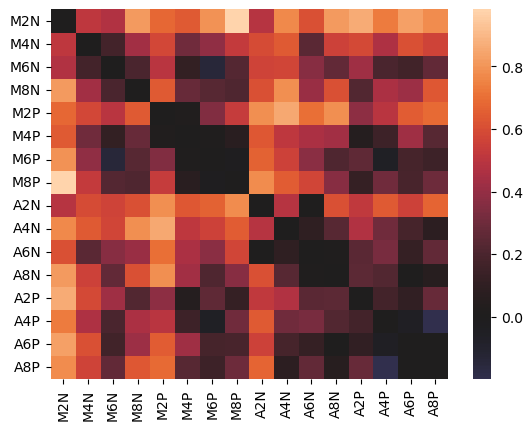

Computing RDMs for sub 34...
(1597, 38, 901)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 294 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1734 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.5min finished


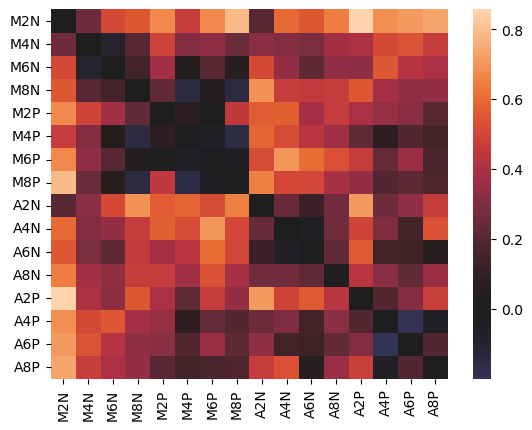

In [6]:
for xfile in sub_files:
    subid = int(xfile.split('/')[-2])
    
    sub_file_out = f'sub_rdms/sub_{str(subid).zfill(3)}.npy'
    if ((not path.exists(sub_file_out)) or OVERWRITE):
        print(f'Computing RDMs for sub {subid}...')

        eeg = np.load(xfile)
        print(eeg.shape)
        chans = pd.read_csv(xfile.replace('_epo.npy', '_chan_labels.csv'), header=None, names=['idx', 'labels'])
        keep_idx = chans.loc[~chans['labels'].isin(DROP_CHANS), 'idx'].values
        eeg = eeg[:, keep_idx, :]  # remove eye tracking, eog, TP9, and any bad channels (Fp1, Fp2)


        eeg = eeg[:, :, trim_idx]

        eeg_time_binned = np.zeros((eeg.shape[0], eeg.shape[1], len(bin_starts)))
        for i,t in enumerate(t_idx_starts):
            eeg_time_binned[..., i] = eeg[..., t:t + 5].mean(axis=-1)  # TODO: change back

        beh = pd.read_csv(xfile.replace('_epo.npy', '_data.csv'))
        if subid == 10:
            beh = beh.iloc[4:]  # first 4 trials weren't recorded for this sub
        beh = beh.loc[~(beh.REJ==1)] # remove real time eye tracking rejects, which aren't in the EEG
        if path.exists(xfile.replace('_epo.npy', '_preArt_selections.npy')):  # sometimes epoching fails, so we need to use the preArt selections to drop those trials
            preArt_selections = np.load(xfile.replace('_epo.npy', '_preArt_selections.npy'))
            beh = beh.iloc[preArt_selections]

        artifact_idx = np.load(xfile.replace('_epo.npy', '_rej_FINAL.npy'))
        artifact_idx = ~artifact_idx.astype(bool)


        eeg_time_binned = eeg_time_binned[artifact_idx]  # remove EEG artifact trials
        beh = beh.loc[artifact_idx] 
        trial_conds = beh['trial_condition'].values

        if subid==1:  # sub 1 had weird makeup trials, with values in wrong columns
            to_replace = pd.Series(trial_conds).isnull().values
            trial_conds[to_replace] = beh['relevant_probe_bin'].values[to_replace] 

        # exclude trials where numbers appears
        numbers_absent = (beh.target_present==0).values
        eeg_time_binned = eeg_time_binned[numbers_absent]
        trial_conds = trial_conds[numbers_absent]
 

        if subid==2:  # sub 002 has a messed up makeup attention block
            bad_makeup = np.array([c=='nan' for c in trial_conds])
            trial_conds = trial_conds[~bad_makeup]
            eeg_time_binned = eeg_time_binned[~bad_makeup]


    
        np.random.seed(2023)  # for reproducibility
        sub_rdms = crossnobis(eeg_time_binned, trial_conds, conditions, n_splits=2_500, n_jobs=-1)
        np.save(sub_file_out, sub_rdms)

        # plot delay-period RDM
        sub_rdm_delay = sub_rdms[...,delay_period].mean(-1)
        sns.heatmap(sub_rdm_delay, xticklabels=conditions, yticklabels=conditions, center=0)
        plt.show()
        plt.close()